# Lab3.5a Testing classifiers on a different data set with tweets


The data set that we are going to use is from a NLP task on emotion detection that was organised in the *Wassa* workshop in 2017. The texts are tweets and therefore a different genre than the spoken utterances from the conversations in the MED data set:

http://saifmohammad.com/WebPages/EmotionIntensity-SharedTask.html

We included the data set in the distribution of this lab and aggregated all the training data in a single file that we now can load using *Pandas*.

### 1. Loading the tweet data set

In [3]:
import pandas as pd
filepath = './data/wassa/training/all.train.tsv'
dftweets = pd.read_csv(filepath, sep='\t')
dftweets.head()

,ID,Tweet,Label,Score
0,10000,How the fu*k! Who the heck! moved my fridge!.....,anger,0.938
1,10001,So my Indian Uber driver just called someone t...,anger,0.896
2,10002,@DPD_UK I asked for my parcel to be delivered ...,anger,0.896
3,10003,so ef whichever butt wipe pulled the fire alar...,anger,0.896
4,10004,Don't join @BTCare they put the phone down on ...,anger,0.896


In [4]:
dftweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3613 entries, 0 to 3612
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      3613 non-null   int64  
 1   Tweet   3613 non-null   object 
 2   Label   3613 non-null   object 
 3   Score   3613 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 113.0+ KB


We see that this data set has 3613 tweets, labels and a score. Lets check the distribution of the labels:

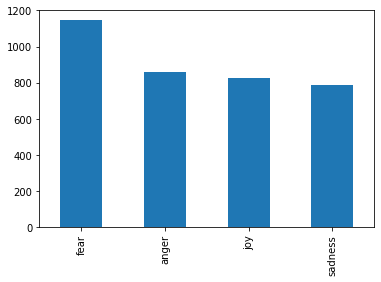

In [5]:
dftweets.Label.value_counts().sort_values(ascending=False).plot(kind='bar')

We see that this data set is more evenly distributed and there are no neutral tweets. Also lacking are *disgust* and *surprise*. Let's see what our classifier does on this data set.

We first extract the tweets and labels using a similar loop as before.

In [6]:
tweet_instances=[]
tweet_labels = []
for tweet in dftweets['Tweet']:
    ### We break the loop after 2000 instances 
    #if index==2000:
    #    break
    tweet_instances.append(tweet)


for label in dftweets['Label']:
    ### We break the loop after 2000 instances 
    #if index==2000:
    #    break    ### we need to surround the next statements with 'try' and 'except' to catch cases 
    tweet_labels.append(label)

print(len(tweet_instances))
print(len(tweet_labels))

3613
3613


### 2. Representing and classifying the tweets as averaged word embeddings

#### 2.1 Representing the tweets using the same word embeddings

We can use the same functions that we used in the notebook *Lab3.4a.ml.emotion-detection.embeddings.ipynb* to get averaged embeddings for the tweets. We repeat these functions in this notebook.

Note that the tweets have special tokens such as hashtags, emoticons. In so far these are not part of the embedding vocabulary, they will not be accounted for.

In [22]:
import nltk
from nltk.corpus import stopwords

In [25]:
unknown_words =[]
known_words = []
# Function to average all word vectors in a paragraph
def featureVecMethod(words, stopwords, model, modelword_index, num_features):
    # Pre-initialising empty numpy array for speed
    # This create a numpy array with the length of the num_features set to zero values
    featureVec = np.zeros(num_features,dtype="float32")
    nwords = 0
        
    for word in  words:
        if not word in stop_words: 
            if word in index2word_set:
                nwords = nwords + 1
                featureVec = np.add(featureVec,model[word])
            else:
                word = word.lower()
                if word in index2word_set:
                    nwords = nwords + 1
                    featureVec = np.add(featureVec,model[word])
                    #we keep track of the words detected
                    known_words.append(word)
                else:
                    #we keep track of the unknown words to see how well our model fits the data
                    unknown_words.append(word)
    # Dividing the result by number of words to get average
    featureVec = np.divide(featureVec, nwords)
    return featureVec

In [26]:
# Function for calculating the average feature vector
def getAvgFeatureVecs(texts, stopwords, model, modelword_index, num_features):
    counter = 0
    textFeatureVecs = np.zeros((len(texts),num_features),dtype="float32")
    for text in texts:
        # Printing a status message every 1000th text
        if counter%200 == 0:
            print("Review %d of %d"%(counter,len(texts)))
            
        textFeatureVecs[counter] = featureVecMethod(text, stopwords, model, modelword_index,num_features)
        counter = counter+1
    return textFeatureVecs

We also need to load the same word embedding model as we used before to get compatible word embeddings for this data.

In [27]:
from gensim.models.word2vec import Word2Vec
import gensim.downloader as api
# download the model and return as object ready for use
word_embedding_model = api.load("glove-twitter-25")

In [29]:
index2word_set = set(word_embedding_model.wv.index2word)
stop_words = set(stopwords.words('english'))

num_features = 25
tweet_tokens = []
for tweet in tweet_instances:
    tweet_tokens.append(nltk.tokenize.word_tokenize(tweet))

tweet_embedding_vectors = getAvgFeatureVecs(tweet_tokens, stop_words, word_embedding_model, index2word_set, num_features)
#### Due to the averaging, there could be infinitive values or NaN values. The next numpy function turns these value to "0" scores
tweet_embedding_vectors = np.nan_to_num(tweet_embedding_vectors)

/Users/piek/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


Review 0 of 3613
Review 200 of 3613
Review 400 of 3613
Review 600 of 3613
Review 800 of 3613
Review 1000 of 3613
Review 1200 of 3613
Review 1400 of 3613
Review 1600 of 3613
Review 1800 of 3613
Review 2000 of 3613
Review 2200 of 3613
Review 2400 of 3613
Review 2600 of 3613
Review 2800 of 3613
Review 3000 of 3613
Review 3200 of 3613
Review 3400 of 3613
Review 3600 of 3613


Next, we need to convert the labels to the same numeric valus that we used before. We should use our LabelEncoder that we used before. However, we want the labels to have the same numeric values as 

In [30]:
from sklearn import preprocessing
# first we instantiate a label encode
le = preprocessing.LabelEncoder()
# we fee this encoder with the complete list of labels from our data
labels = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']
le.fit(labels)
print(list(le.classes_))
tweet_classes = le.transform(tweet_labels)
print(list(tweet_classes[0:20]))

['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


We see that the first set of tweets are all expressing *anger* which makes sense given the way the data were concatenated from the separate files with tweets.

#### 2.2 Loading the classifier for embedding representations

In [17]:
from sklearn.metrics.pairwise import cosine_similarity
import gensim
import numpy as np

In [19]:
import pickle
filename_classifier = 'svm_nonlinear_clf_embeddings.sav'

# load the classifier and the vectorizer from disk
svm_nonlinear_clf = pickle.load(open(filename_classifier, 'rb'))


In [31]:
# have classifier make a prediction
tweet_pred_nonlinear_embeddings = svm_nonlinear_clf.predict(tweet_embedding_vectors)

In [32]:
from sklearn.metrics import classification_report

report = classification_report(tweet_classes,tweet_pred_nonlinear_embeddings,digits = 7)
print(le.classes_)
print('SVM NONLINEAR EMBEDDINGS ----------------------------------------------------------------')
print(report)

['anger' 'disgust' 'fear' 'joy' 'neutral' 'sadness' 'surprise']
SVM NONLINEAR EMBEDDINGS ----------------------------------------------------------------
              precision    recall  f1-score   support

           0  0.0000000 0.0000000 0.0000000       857
           2  0.0000000 0.0000000 0.0000000      1147
           3  0.3990536 0.3074119 0.3472889       823
           4  0.0000000 0.0000000 0.0000000         0
           5  0.0000000 0.0000000 0.0000000       786
           6  0.0000000 0.0000000 0.0000000         0

    accuracy                      0.0700249      3613
   macro avg  0.0665089 0.0512353 0.0578815      3613
weighted avg  0.0908998 0.0700249 0.0791084      3613



/Users/piek/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/piek/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 3. Representing and classifying the tweets as a bag-of-words vector

#### 3.1 Representing the tweets as BoW vectors

In order to represent the tweets according to our BoW vector representation derived from the MELD data, we need to load the *utterance_vec* file that we saved before.

In [33]:
# load the classifier and the vectorizer from disk
filename_vectorizer = 'utterance_vec.sav'
loaded_vectorizer = pickle.load(open(filename_vectorizer, 'rb'))

We can now apply the transform function to the tokenized tweets.

In [39]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

#tfidf_transformer = TfidfTransformer()
#utterance_tfidf = tfidf_transformer.fit_transform(utterance_counts)
tweet_vectors = loaded_vectorizer.transform(tweet_instances)
tweet_vectors.shape

(3613, 1151)

We can see that the matrix has vectors of the same size as before for the BoW token vectors.

We can now load the classifier and make the prediction in this data.

In [42]:
# the classifier on disk
filename_classifier = 'svm_linear_clf_bow.sav'

loaded_bow_classifier = pickle.load(open(filename_classifier, 'rb'))

pred_from_loaded_bow_classifier = loaded_bow_classifier.predict(tweet_vectors)

In [43]:
from sklearn.metrics import classification_report

report = classification_report(tweet_classes,pred_from_loaded_bow_classifier,digits = 7)
print(le.classes_)
print('SVM LINEAR BOW ----------------------------------------------------------------')
print(report)

['anger' 'disgust' 'fear' 'joy' 'neutral' 'sadness' 'surprise']
SVM LINEAR BOW ----------------------------------------------------------------
              precision    recall  f1-score   support

           0  0.2413793 0.0816803 0.1220575       857
           1  0.0000000 0.0000000 0.0000000         0
           2  0.5714286 0.0069747 0.0137812      1147
           3  0.3736655 0.3827461 0.3781513       823
           4  0.0000000 0.0000000 0.0000000         0
           5  0.3781095 0.0966921 0.1540020       786
           6  0.0000000 0.0000000 0.0000000         0

    accuracy                      0.1298090      3613
   macro avg  0.2235118 0.0811562 0.0954274      3613
weighted avg  0.4060369 0.1298090 0.1529683      3613

